In [6]:
import os
import json
import pandas as pd

def load_result(folder_name):
  ret = []
  for fn in os.listdir(folder_name):
    if ".json" in fn:
      with open(f"{folder_name}/{fn}", "r") as f:
        ret.append(json.loads(f.read()))
  
  # format random search: get rid of the time array
  for r in ret:
    if "fasttext_time" in r:
      r.update({"fasttext_random_search": r['fasttext_time']["scores"]})
      del r["fasttext_time"]

  return ret

def merge_results(a, b):
  for x in a:
    for y in b:
      if x["data_id"] == y["data_id"]:
        x.update(y)

res = load_result("openml-cc18-res")
merge_results(res, load_result("openml-cc18-ft-300"))
merge_results(res, load_result("openml-cc18-dummy"))
merge_results(res, load_result("openml-cc18-random-forest"))
merge_results(res, load_result("openml-cc18-ft-autotuned"))
merge_results(res, load_result("openml-cc18-ft-random-search"))

In [7]:
res

[{'data_id': 1049,
  'name': 'pc4',
  'metric': 'roc_auc',
  'fasttext': [0.8219401041666666,
   0.8627387152777777,
   0.7781032986111109,
   0.8099330357142857,
   0.8180803571428572],
  'fasttext_100': [0.8412543402777777,
   0.8381076388888888,
   0.7825520833333334,
   0.8229910714285715,
   0.7975446428571429],
  'fasttext_300': [0.8395182291666666,
   0.83984375,
   0.7858072916666666,
   0.8176339285714286,
   0.8024553571428571],
  'constantpredictor': [0.5, 0.5, 0.5, 0.5, 0.5],
  'RandomForest': [0.9040256076388888,
   0.9104275173611112,
   0.8596462673611112,
   0.8770647321428571,
   0.8616071428571429],
  'fasttext_autotune': [0.8683810763888888,
   0.8792317708333333,
   0.8195529513888888,
   0.7328683035714285,
   0.8233258928571429],
  'fasttext_random_search': [0.8582899305555555,
   0.8741319444444444,
   0.791015625,
   0.8510044642857142,
   0.8238839285714286]},
 {'data_id': 300,
  'name': 'isolet',
  'metric': 'neg_log_loss',
  'fasttext': [-3.258096720875293,
 

/var/folders/cg/7qw4190j34n5fvvh2k9knv7w0000gn/T/ipykernel_1579/3891793878.py:19: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = compute_CD(avg_ranks, n=len(rankings), test="nemenyi")
/var/folders/cg/7qw4190j34n5fvvh2k9knv7w0000gn/T/ipykernel_1579/3891793878.py:20: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  graph_ranks(avg_ranks, method_names, cd=cd)


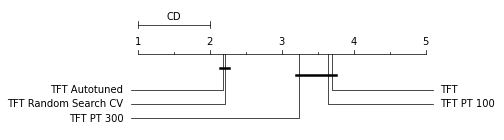

/var/folders/cg/7qw4190j34n5fvvh2k9knv7w0000gn/T/ipykernel_1579/3891793878.py:19: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = compute_CD(avg_ranks, n=len(rankings), test="nemenyi")
/var/folders/cg/7qw4190j34n5fvvh2k9knv7w0000gn/T/ipykernel_1579/3891793878.py:20: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  graph_ranks(avg_ranks, method_names, cd=cd)


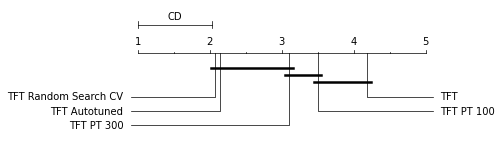

In [12]:
import pandas as pd
from scipy.stats import rankdata
from Orange.evaluation import compute_CD, graph_ranks
import matplotlib.pyplot as plt
import numpy as np

methods = ["fasttext", "fasttext_100", "fasttext_300", "fasttext_autotune", "fasttext_random_search"]
method_names = ["TFT", "TFT PT 100", "TFT PT 300", "TFT Autotuned", "TFT Random Search CV"]


def plot_cd(res, methods, metric):
  rankings = []
  for r in res:
    if r['metric'] == metric:
      # negative mean because rankdata ranks based on taking the minimum value
      rankings.append(rankdata([-np.mean(r[m]) for m in methods], method="average"))
  rankings = pd.DataFrame(rankings, columns=methods)
  avg_ranks = [np.mean(rankings[m]) for m in methods]
  cd = compute_CD(avg_ranks, n=len(rankings), test="nemenyi")
  graph_ranks(avg_ranks, method_names, cd=cd)
  plt.show()

plot_cd(res, methods, metric="neg_log_loss")
plot_cd(res, methods, metric="roc_auc")

/var/folders/cg/7qw4190j34n5fvvh2k9knv7w0000gn/T/ipykernel_1579/3813365509.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([m for m in method_names if m != "TFT"])


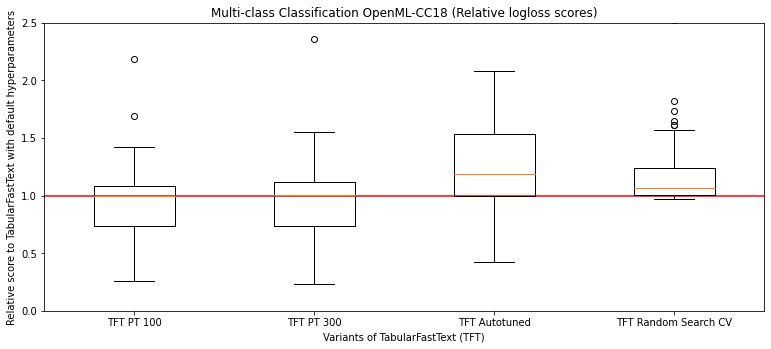

/var/folders/cg/7qw4190j34n5fvvh2k9knv7w0000gn/T/ipykernel_1579/3813365509.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([m for m in method_names if m != "TFT"])


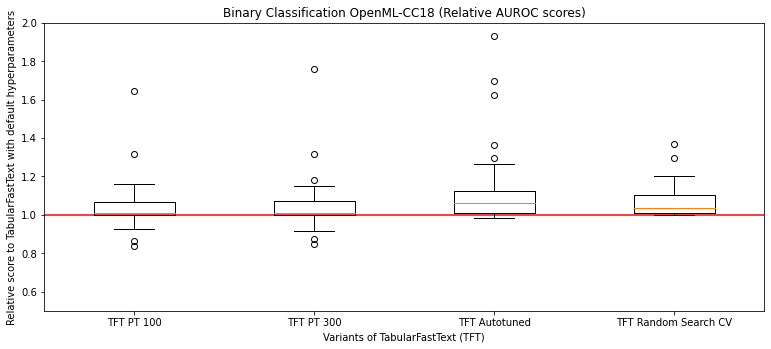

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

methods = ["fasttext", "fasttext_100", "fasttext_300", "fasttext_autotune", "fasttext_random_search"]
method_names = ["TFT", "TFT PT 100", "TFT PT 300", "TFT Autotuned", "TFT Random Search CV"]

def get_relative_scores(res, methods, metric, baseline):
  ret = []
  for m in methods:
    if m != baseline:
      ret.append([np.mean(r[m] / np.mean(r['fasttext'])) for r in res if r['metric'] == metric])
  return ret

def plot_relative_scores(data, baseline, title, ylim):
  fig = plt.figure(figsize =(10, 4))
  # Creating axes instance
  ax = fig.add_axes([0, 0, 1, 1])
  plt.axhline(1, color="red")
  ax.set_xticklabels([m for m in method_names if m != "TFT"])
  ax.set_ylim(ylim)
  ax.set_title(title)
  ax.set_xlabel("Variants of TabularFastText (TFT)")
  ax.set_ylabel("Relative score to TabularFastText with default hyperparameters")
  # Creating plot
  bp = ax.boxplot(data)
  # show plot
  plt.show()
  
def mapping(data):
  ret = np.array(data)
  ret = 1 / ret
  return list(ret)


multi_data = get_relative_scores(res, methods, "neg_log_loss", "fasttext")
plot_relative_scores(mapping(multi_data), "fasttext" , 
                     title="Multi-class Classification OpenML-CC18 (Relative logloss scores)", 
                     ylim=(0, 2.5))

bin_data = get_relative_scores(res, methods, "roc_auc", "fasttext")
plot_relative_scores(bin_data, "fasttext" , 
                     title="Binary Classification OpenML-CC18 (Relative AUROC scores)", 
                     ylim=(0.5, 2))